# Introduction

The goal of this initial analysis is to load data about imports, exports, and domestic production of various food types, relevant to Switzerland. Please see the `README` for overall project goals and background information.

In [ ]:
# import external libraries
%matplotlib inline
import collections
import inspect
import pickle
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go #may not need this
import holoviews as hv
from holoviews import opts
import networkx as nx
from networkx.algorithms import bipartite
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # prevents internal problem with networkx from showing error

%load_ext autoreload
%autoreload 2

In [ ]:
# import local dependencies
import sys
sys.path.insert(1, "scripts")

from helpers import *
from plots import *
from impex_data_manipulation import *
from fao_data_manipulation import *
from emissions_data_manipulation import *
from data_analysis import *

The first step is to calculate, for each type of food, how much of what is consumed by the Swiss population is produced within Switzerland versus imported. To do this, we will combine 3 sets of data: imports, exports, and domestic production. The imports and exports data are sourced from [Swiss Impex](https://www.gate.ezv.admin.ch/swissimpex/index.xhtml), a website hosted by the Swiss Federal Customs Administration which provides data on Switzerland's global trade activity. Domestic production data comes from [FAOStat](http://www.fao.org/faostat/en/#data), the Food and Agriculture Organization of the United Nations which offers a variety of agricultural-related data. In theory, the amount of food consumed in Switzerland (including food waste) can be calculated from these datasets:
#### Also add the website from FAO that had the fish and seafood data

Food consumed = domestic production + imports - exports

Note that the Swiss Federal Statistics Office also provided relevant data--namely, it has a dataset on Swiss food consumption by type of food. Unfortunately, these data conflicted with the data from FAO and Swiss Impex. Since the Federal Statistics Office data was much less detailed (for instance, more general/broad food categories), we decided to focus on Impex and FAO, knowing that the numbers must be taken with a grain of salt since it is difficult to accurately quantify such data.

Let's load all the data and then combine the various data sets to get the values of interest. First we'll load imports and exports data from Impex. The data is spread across multiple Excel files and sheets.

***
**Data loading and manipulation**
***

Let's start with loading the Swiss Impex into the `impex` dataframe:

In [146]:
impex = load_impex()
impex.head()

type                     fruits                                          \
subtype    plantains_and_others             bananas               dates   
indicator               imports exports     imports  exports    imports   
total                 1444222.0     2.0  92397628.0  36763.0  2706334.0   
Argentina                 396.0     0.0         0.0      0.0        0.0   
Bangladesh                130.0     0.0         0.0      0.0        0.0   
Brazil                   1229.0     0.0      1301.0      0.0        0.0   
Cameroon                 1529.0     0.0     65786.0      0.0        0.0   

type                                                          ...  \
subtype                   figs           pineapples           ...   
indicator   exports    imports  exports     imports  exports  ...   
total       96471.0  3681429.0  56065.0  20809608.0  70821.0  ...   
Argentina       0.0     8783.0      0.0         0.0      0.0  ...   
Bangladesh      0.0        0.0      0.0         0.0      0.0  ...   
Brazil          0.0    42844.0      0.0       891.0      0.0  ...   
Cameroon        0.0        0.0      0.0    213628.0      0.0  ...   

type                        seafood                                            \
subtype    squid_octopus_cuttlefish         shrimp_prawns            molluscs   
indicator                   imports exports       imports  exports    imports   
total                     2363868.0  1415.0     4833926.0  27932.0  3390293.0   
Argentina                    3010.0     0.0       36848.0      0.0        0.0   
Bangladesh                      0.0     0.0      236612.0      0.0        0.0   
Brazil                        496.0     0.0           0.0      0.0        0.0   
Cameroon                        0.0     0.0           0.0      0.0        0.0   

type                                                           
subtype            lobster_crab                fish            
indicator  exports      imports exports     imports   exports  
total        240.0     715883.0  4923.0  34298964.0  153535.0  
Argentina      0.0        144.0     0.0     13205.0       0.0  
Bangladesh     0.0          0.0     0.0         0.0       0.0  
Brazil         0.0        380.0     0.0      6108.0       0.0  
Cameroon       0.0          0.0     0.0       150.0       0.0  

[5 rows x 176 columns]

To ensure that our data is properly processed and handled as is goes through the changes we are about to expose it to, we will pull out one value of this dataframe (kiwi fruits imported from New Zealand) and check at the end to make sure its value is still properly matched with the country and fruit.

In [147]:
impex.loc["New Zealand"].fruits.kiwi_fruit.imports

3241114.0

We then create a dataframe `impex_total` for storing total quantities for indicator variables:

In [148]:
# 1. Select only first row (total), creates a series
# 2. Unstack first level (indicator) to create a dataframe
impex_total = impex.iloc[0].unstack("indicator")
impex_total.head()

indicator                      exports     imports
type            subtype                           
animal_products butter       2085954.0    155312.0
                cheese      67285451.0  60637898.0
                eggs          442894.0  36298734.0
                honey         685704.0   8191947.0
                milk_cream  14990772.0  29234598.0

Let's now further manipulate the original `impex` dataframe to include information about the continents and sub-continents in the index:

In [149]:
# First we drop the total row
impex = impex.drop("total")

# Second, we load the country-continent info
continents = load_countries_continents()

# Finally, we compute the new index
countries_mindex = pd.MultiIndex.from_arrays(continents.values.T, names=continents.columns)
impex_mindex = countries_mindex[countries_mindex.get_level_values(2).isin(impex.index)]

# re-sort the original impex dataframe so it matches the incoming impex_mindex
# since impex is sorted alphabetically, and the impex_mindex does NOT match on country, it just matches by row number
impex = impex.reindex(impex_mindex.get_level_values(2))

# now apply the new index to the properly sorted impex df
impex.set_index(impex_mindex, inplace=True)
impex.index.names

FrozenList(['continent', 'subcontinent', 'country'])

In [150]:
# double check that the numbers copied over correctly/stayed with their correct labels
impex.xs("New Zealand", level="country", drop_level=False).fruits.kiwi_fruit.imports

continent  subcontinent  country    
Oceania    Oceania       New Zealand    3241114.0
Name: imports, dtype: float64

Note that the `impex` frame should only contain information about food destined for humans. We were careful to ensure this was true: all items which can also be imported for the use of animal feed were selected by their subcategory of being specifically for human consumption. 

Now, let's load the data on Swiss domestic `production` from FAO:

In [151]:
production = load_fao()
production.head()

indicator                     production
type            subtype                 
animal_products butter      4.843600e+07
                cheese      2.063360e+08
                eggs        5.763500e+07
                honey       3.084000e+06
                milk_cream  4.795811e+09

In this data as well, we were careful that only crops produced for human consumption are measured. This is specified in the FAO metadata.

Next we perform an outer join of `impex_total` and `production` to create a meta-dataframe, `suisse` with all total macroeconomic indicators for each commodity subtype:

In [152]:
suisse = impex_total.join(production, how="outer")
suisse.head()

indicator                      exports     imports    production
type            subtype                                         
animal_products butter       2085954.0    155312.0  4.843600e+07
                cheese      67285451.0  60637898.0  2.063360e+08
                eggs          442894.0  36298734.0  5.763500e+07
                honey         685704.0   8191947.0  3.084000e+06
                milk_cream  14990772.0  29234598.0  4.795811e+09

We have three possibilities for each commodity
1. Neither production or import/export values are given or they all sum up to 0
2. Either only production values are given or only import/export values are given
3. Production, import and export values are all given (and are non-zero)

Commodities fulfilling the first condition will be removed. Commodities fulfilling the second or third condition will be kept.

<em style="font-size: 12px">Note: Missing or 0-valued data may be due to either the values actually being 0 or the data not being collected on these items. Since there is no way of knowing which is the case, we will assume that the values are indeed truly 0 to enable their utilization in the analysis.</em>

In [153]:
# Remove subtypes for which all given quantities sum up to 0
subtypes_no_info = suisse.index[suisse.sum(axis=1) == 0]
suisse.drop(subtypes_no_info, inplace=True)

Next, we shall add columns for `domestic_consumption` and `imported_consumption`.

Definitions:
* **domestic consumption**: goods and services consumed in the country where they are produced
* **imported consumption**: goods and services consumed in the country to which they are imported

**Note**: in this analysis we will make the following simplified assumptions:

* food waste is included as being "consumed"
* exported quantity is first satisfied by available produced quantity, and then imported quantity

In [154]:
# If exports > production, then we say all produced quantity
# is exported and the rest of exported quantity is satisfied by imports:
# 1. Set domestic_consumption to zero
# 2. Set imported_consumption to imports-(exports-production)

# If exports <= production, we say all exports
# is satisfied by domestic production: 
# 1. Set domestic_consumption to production-exports
# 2. Set imported_consumption to imports
suisse["domestic_consumption"] = np.where(
    suisse.exports > suisse.production,
    0,
    suisse.production - suisse.exports
)

suisse["imported_consumption"] = np.where(
    suisse.exports > suisse.production,
    suisse.imports - suisse.exports + suisse.production,
    suisse.imports
)

suisse["consumption"] = suisse.domestic_consumption + suisse.imported_consumption

suisse.head()

indicator                      exports     imports    production  \
type            subtype                                            
animal_products butter       2085954.0    155312.0  4.843600e+07   
                cheese      67285451.0  60637898.0  2.063360e+08   
                eggs          442894.0  36298734.0  5.763500e+07   
                honey         685704.0   8191947.0  3.084000e+06   
                milk_cream  14990772.0  29234598.0  4.795811e+09   

indicator                   domestic_consumption  imported_consumption  \
type            subtype                                                  
animal_products butter              4.635005e+07              155312.0   
                cheese              1.390505e+08            60637898.0   
                eggs                5.719211e+07            36298734.0   
                honey               2.398296e+06             8191947.0   
                milk_cream          4.780820e+09            29234598.0   

indicator                    consumption  
type            subtype                   
animal_products butter      4.650536e+07  
                cheese      1.996884e+08  
                eggs        9.349084e+07  
                honey       1.059024e+07  
                milk_cream  4.810055e+09

***
**Data analysis and visualization**
***

Let's plot imports and exports per meta-type:

In [155]:
# 1. Group by meta-type
# 2. Sum the totals
# 3. Unstack the columns to create a Series
impex_total_metatype = impex_total.groupby("type").sum().unstack()

In [156]:
impex_total_metatype

indicator  type           
exports    animal_products    168582740.0
           cereals              2723041.0
           fruits               4131495.0
           meat                 4940547.0
           seafood               188045.0
           vegetables           8819228.0
imports    animal_products    152945114.0
           cereals            309036367.0
           fruits             513223401.0
           meat                80153568.0
           seafood             45602934.0
           vegetables         271520646.0
dtype: float64

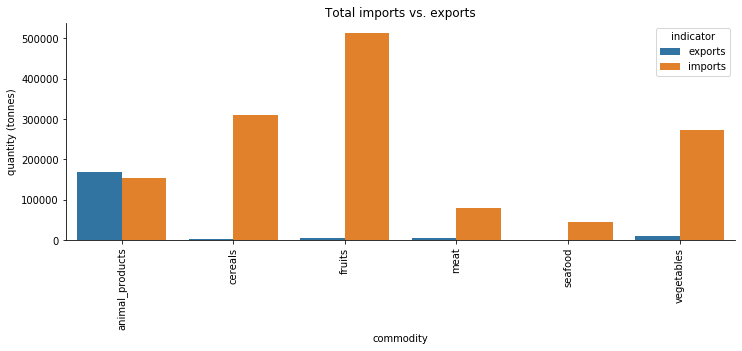

In [157]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=impex_total_metatype.index.get_level_values("type"),
    y=impex_total_metatype.values / 1000,  # kg --> tonnes
    hue=impex_total_metatype.index.get_level_values("indicator"),
)

ax.set(
    title="Total imports vs. exports", xlabel="commodity", ylabel="quantity (tonnes)"
)
plt.xticks(rotation=90)
sns.despine()
plt.savefig("../docs/img/total_imports_vs_exports.jpg", dpi=100, bbox_inches='tight')

As you can see, Switzerland imports many more fruits, vegetables and meats than it exports. The `animal_products` category is interesting, because import and export quantities are about equal. What would make the most sense is if Switzerland imports different animal products than it exports (rather than the same products being both imported and exported). Let's test this theory by looking at imports and exports for the subcategories of `animal_products`:

In [ ]:
impex_total_animal_prods = impex_total.loc["animal_products"].groupby("subtype").sum().unstack()

In [ ]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=impex_total_animal_prods.index.get_level_values("subtype"),
    y=impex_total_animal_prods.values / 1000,  # kg --> tonnes
    hue=impex_total_animal_prods.index.get_level_values("indicator"),
)

ax.set(
    title="Imports vs. exports of animal products", xlabel="commodity", ylabel="quantity (tonnes)"
)
plt.xticks(rotation=90)
sns.despine()
plt.savefig("../docs/img/imports_vs_exports_animal_products.jpg", dpi=100, bbox_inches='tight')

This graph brings more light to the topic. Cheese, a category of which there are many different flavors and consumers like variety, is both heavily imported and exported, likely giving consumers access to a wider variety of cheese types. Eggs, on the other hand, are nearly exclusively imported, while whey is mostly exported.

The butter category of this graph is a good transition to the continuation of the analysis; just because butter is hardly imported nor exported does not mean the Swiss do not eat butter! Rather, imports and exports are only part of the broader picture since domestic production is another important consideration. One possible hypothesis for why butter is neither imported nor exported in large quantities is because domestic production is nearly equal to domestic consumption.

#### Bipartite graph between continents and meta food groups, weighted by amounts of food imported from those continents

In [ ]:
# make the nodes: continents on the left, food groups on the right
continents = impex.index.get_level_values(0).unique().array
meta_food_groups = impex.columns.levels[0].array
bi = nx.Graph()
bi.add_nodes_from(continents, bipartite=1)
bi.add_nodes_from(meta_food_groups, bipartite=0)

# make an edge between each continent and each food group
edges = []
for continent in continents:
    for food in meta_food_groups:
        edges.append((continent, food))
        
bi.add_edges_from(edges, weight=3)

In [ ]:
# calculate the initial raw weights, which is the total amount of food for each continent-food pair
weights = []
for continent in continents:
    for food in meta_food_groups:
        total_food_amount = impex.xs(continent)[food].xs('imports', level=1, axis=1).to_numpy().sum()
        weights.append(total_food_amount)
        
# incorporate these weights into the data for each edge
for num, name in enumerate(bi.edges(data=True)):
    name[2]['weight'] = weights[num]

In [ ]:
#make a list of all the weights so can edit them
all_weights = []
for (node1,node2,data) in bi.edges(data=True):
    all_weights.append(data['weight'])
    #print(data['weight']) # this is totals by continent per meta food group

# normalize the weights so they are appropriate for the graph
for num, wt in enumerate(all_weights):
    all_weights[num] = wt*len(continents)*5/sum(weights)
    
# incorporate the normalized weights into the edge data for use in the graph
for num, name in enumerate(bi.edges(data=True)):
    name[2]['weight'] = all_weights[num]


top = nx.bipartite.sets(bi)[0]
pos = nx.bipartite_layout(bi, top)

# the old, non-interactive graph
#nx.draw_networkx(bi, pos, font_size=12, node_size=900, node_color='red', node_shape='s', width=all_weights)

In [ ]:
# make an interactive bipartite graph with Holoviews and Bokeh
bipartite = hv.Graph.from_networkx(bi, pos, width=all_weights)

# create text labels for each of the nodes
labs = ['Africa', 'America', 'Asia', 'Europe','Oceania','animal_products', 'cereals', 'fruits', 'meat', 'seafood', 'vegetables']
labels = hv.Labels({('x', 'y'): bipartite.nodes.array([0,1]), 'text': labs}, ['x', 'y'], 'text')

# plot the graph with labels
hv.extension('bokeh')
# this padding feature was working previously and then broke, so I edited it a bit...
#padding = dict(x=(-1.3, 1.3), y=(-0.9, 1)) # make graph display slightly larger than data
#(bipartite*labels).relabel("Food Type Imports by Continent").redim.range(**padding).opts(
(bipartite*labels).relabel("Food Type Imports by Continent").opts(
    opts.Labels(text_color='text', cmap='Category20', yoffset=0.13, fontsize=14, padding=0.2),
    #opts.Points(color='black', size=25), 
    opts.Graph(node_size=30, inspection_policy='edges', fontsize={'title':20},
               node_hover_fill_color='red', edge_line_width='weight', xaxis=None, yaxis=None, node_fill_color='lightgray',
               edge_hover_fill_color='red', frame_height=400, frame_width=600, padding=((0.1, 0.15), (0.1, 0.2))))

In [ ]:
# TODO: change the weights that show when hovering--these are the normalized weights, we want the actual kg of food
# TODO: figure out why the hover edges are green instead of red
# TODO: find a way to color the continent labels one color and the food labels another color
# TODO: remove the "start" and "end" in the hover labels, just say continent and food
# TODO MAYBE: add a widget to toggle between inspection_policy of edges vs nodes

## Emissions


Now that we have calculated Switzerland's production and consumption, we want to have a look at how this translates in terms of equivalent CO$_2$ production. To do this, we could look at Swiss-specific values for the greenhouse gas production for different food types, however data from other countries is very sparse and reliable data for many food types is only available for certain countries. Later in the analysis, we want to compare Swiss production emissions with Swiss import emissions, therefore for consistency we need to either have data available for all (or most) countries for a given product, or use global averages. Comprehensive data is available on meat and cereal production emissions worldwide, however fruit and vegetable figures are much harder to obtain and only a limited number of studies have been carried out. These studies have been accumulated in a systematic review (https://www.sciencedirect.com/science/article/pii/S0959652616303584) and these values have been used to calculate averages for a number of different kinds of produce. To ensure our results are consistent, we will use this generalisation of global average values to estimate the domestic Swiss emissions for fruit and vegetables.

<!---
Other thought: I've currently created a dictionary to map the different fruit/veg to the impex categories. Was just thinking, this could be a potential spot to use machine learning, although admittedly not a very useful one...
--->

In [158]:
emissions = load_emissions()
emissions.head()

,Median,Mean,Stdev,Min,Max,Q1,Q3,No. of LCA studies,No. of GWP values
name,,,,,,,,,
almond/coconut milk,0.42,0.42,0.03,0.39,0.44,0.39,0.44,1.0,4.0
almonds,1.54,1.74,1.25,0.51,3.77,0.76,2.33,4.0,6.0
anglerfish,12.29,12.29,2.63,10.43,14.15,11.36,13.22,2.0,2.0
apples,0.29,0.36,0.19,0.18,0.89,0.21,0.47,21.0,33.0
apricots,0.43,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [159]:
# integrate the median emissions values into this dataframe
suisse = add_emissions_data(suisse, emissions)
suisse.head()

exports     imports   production  \
type            subtype                                        
animal_products butter    2085954.0    155312.0   48436000.0   
                cheese   67285451.0  60637898.0  206336000.0   
                whey     77624196.0   8145149.0   63000000.0   
                eggs       442894.0  36298734.0   57635000.0   
                honey      685704.0   8191947.0    3084000.0   

                         domestic_consumption  imported_consumption  \
type            subtype                                               
animal_products butter             46350046.0              155312.0   
                cheese            139050549.0            60637898.0   
                whey                      0.0            -6479047.0   
                eggs               57192106.0            36298734.0   
                honey               2398296.0             8191947.0   

                         consumption emissions_category  median_emissions  
type            subtype                                                    
animal_products butter    46505358.0             butter              9.25  
                cheese   199688447.0             cheese              8.55  
                whey      -6479047.0             cheese              8.55  
                eggs      93490840.0               eggs              3.46  
                honey     10590243.0              honey              0.00

In [160]:
suisse

exports     imports  \
type            subtype                                              
animal_products butter                       2085954.0    155312.0   
                cheese                      67285451.0  60637898.0   
                whey                        77624196.0   8145149.0   
                eggs                          442894.0  36298734.0   
                honey                         685704.0   8191947.0   
...                                                ...         ...   
vegetables      yams                               0.0    152811.0   
                pumpkins_squash_and_gourds       828.0  19109064.0   
                soybeans                      132235.0   1754026.0   
                spinach                         1893.0   1778013.0   
                tomatoes                       24993.0  37244968.0   

                                             production  domestic_consumption  \
type            subtype                                                         
animal_products butter                       48436000.0            46350046.0   
                cheese                      206336000.0           139050549.0   
                whey                         63000000.0                   0.0   
                eggs                         57635000.0            57192106.0   
                honey                         3084000.0             2398296.0   
...                                                 ...                   ...   
vegetables      yams                                0.0                   0.0   
                pumpkins_squash_and_gourds   19931000.0            19930172.0   
                soybeans                      5642000.0             5509765.0   
                spinach                      16135000.0            16133107.0   
                tomatoes                     42533000.0            42508007.0   

                                            imported_consumption  consumption  \
type            subtype                                                         
animal_products butter                                  155312.0   46505358.0   
                cheese                                60637898.0  199688447.0   
                whey                                  -6479047.0   -6479047.0   
                eggs                                  36298734.0   93490840.0   
                honey                                  8191947.0   10590243.0   
...                                                          ...          ...   
vegetables      yams                                    152811.0     152811.0   
                pumpkins_squash_and_gourds            19109064.0   39039236.0   
                soybeans                               1754026.0    7263791.0   
                spinach                                1778013.0   17911120.0   
                tomatoes                              37244968.0   79752975.0   

                                                    emissions_category  \
type            subtype                                                  
animal_products butter                                          butter   
                cheese                                          cheese   
                whey                                            cheese   
                eggs                                              eggs   
                honey                                            honey   
...                                                                ...   
vegetables      yams                                          potatoes   
                pumpkins_squash_and_gourds  pumpkins_squash_and_gourds   
                soybeans                                      soybeans   
                spinach                                        spinach   
                tomatoes                                      tomatoes   

                                            median_emissions  
ty

So assuming that domestic transport is negligible, we can estimate the equivalent CO$_2$ emissions for each product type, using the global average values.

In [161]:
# calculate the emissions (resulting from production of the products)
suisse = production_emissions(suisse)
suisse.head()

exports     imports   production  \
type            subtype                                        
animal_products butter    2085954.0    155312.0   48436000.0   
                cheese   67285451.0  60637898.0  206336000.0   
                whey     77624196.0   8145149.0   63000000.0   
                eggs       442894.0  36298734.0   57635000.0   
                honey      685704.0   8191947.0    3084000.0   

                         domestic_consumption  imported_consumption  \
type            subtype                                               
animal_products butter             46350046.0              155312.0   
                cheese            139050549.0            60637898.0   
                whey                      0.0            -6479047.0   
                eggs               57192106.0            36298734.0   
                honey               2398296.0             8191947.0   

                         consumption emissions_category  median_emissions  \
type            subtype                                                     
animal_products butter    46505358.0             butter              9.25   
                cheese   199688447.0             cheese              8.55   
                whey      -6479047.0             cheese              8.55   
                eggs      93490840.0               eggs              3.46   
                honey     10590243.0              honey              0.00   

                         emissions_sans_transport  
type            subtype                            
animal_products butter               4.301746e+08  
                cheese               1.707336e+09  
                whey                -5.539585e+07  
                eggs                 3.234783e+08  
                honey                0.000000e+00

The final column of the above table shows the total CO$_2$ equivalent (kg) that would be produced if everything that was consumed in Switzerland was domestically produced, i.e. no transport emissions were considered and Swiss-specific CO$_2$ emissions were used for meat and cereal production. Evidently, it is not possible to produce everything that a current consumer buys locally, so in the following analysis we will consider the effect that these imported products and 'food miles' have on the CO$_2$ emissions resulting from Swiss consumption. 

## Transport Analysis

In [ ]:
countries = country_distances()
countries.head()

In [162]:
transport = load_impex_transport()
transport.tail(10)

food_type                                 cereals    potatoes  \
commercial_partner mode_of_transport                            
Zambia             total                      0.0         0.0   
Zimbabwe           Air traffic              145.0         0.0   
                   Inland waterways           0.0         0.0   
                   Road traffic               0.0         0.0   
                   total                    145.0         0.0   
total              Air traffic            15007.0        10.0   
                   Inland waterways    86109369.0         0.0   
                   Rail traffic       108157836.0         5.0   
                   Road traffic        98237354.0  57721581.0   
                   total              292519566.0  57721596.0   

food_type                             other_fresh_fruits_vegetables  \
commercial_partner mode_of_transport                                  
Zambia             total                                      208.0   
Zimbabwe           Air traffic                              10407.0   
                   Inland waterways                             0.0   
                   Road traffic                            178448.0   
                   total                                   188855.0   
total              Air traffic                            8955957.0   
                   Inland waterways                       4241550.0   
                   Rail traffic                          19303446.0   
                   Road traffic                         763220093.0   
                   total                                795721046.0   

food_type                                   fish         meat  dairy_products  
commercial_partner mode_of_transport                                           
Zambia             total                     0.0          0.0             0.0  
Zimbabwe           Air traffic               0.0          0.0             0.0  
                   Inland waterways          0.0          0.0             0.0  
                   Road traffic              0.0        578.0             0.0  
                   total                     0.0        578.0             0.0  
total              Air traffic          813671.0    4476877.0         56453.0  
                   Inland waterways      82829.0     597599.0          4256.0  
                   Rail traffic          11525.0    5869676.0       5360330.0  
                   Road traffic       13125918.0  130663048.0     124257694.0  
                   total              14033943.0  141607200.0     129678733.0

Now, we'll remove the totals for each country and store in a separate dataframe

In [101]:
transport_total = transport.xs("total", level=1)
transport = transport.drop(index="total", level=1)

In [102]:
# define a function which, for each row of 'transport', calculate the fractions for each food group transported by
# each method of transport
def calculate_percent_by_method(row):
    country = row.name[0]
    total = transport_total.loc[country]
    fractions = [row['cereals']/total['cereals'], \
                 row['potatoes']/total['potatoes'], \
                 row['other_fresh_fruits_vegetables']/total['other_fresh_fruits_vegetables'], \
                 row['fish']/total['fish'], \
                 row['meat']/total['meat'], \
                 row['dairy_products']/total['dairy_products']]
    return pd.Series(np.nan_to_num(fractions))

In [163]:
# run the function on the whole df
np.seterr('ignore') # ignore divisions by 0 (when the total imports is 0)
transport[['cereals', 'potatoes', 'other_fresh_fruits_vegetables', 'fish', 'meat', 'dairy_products']] = transport.apply(calculate_percent_by_method, axis=1)

In [164]:
transport.head(10)

food_type                             cereals  potatoes  \
commercial_partner mode_of_transport                      
Afghanistan        Road traffic           0.0       0.0   
                   total                  0.0       0.0   
Albania            Air traffic            0.0       0.0   
                   Road traffic           0.0       0.0   
                   total                  0.0       0.0   
Algeria            Air traffic            0.0       0.0   
                   Rail traffic           0.0       0.0   
                   Road traffic           1.0       0.0   
                   total                  1.0       0.0   
Andorra            Road traffic           0.0       1.0   

food_type                             other_fresh_fruits_vegetables  fish  \
commercial_partner mode_of_transport                                        
Afghanistan        Road traffic                            0.000000   0.0   
                   total                                   0.000000   0.0   
Albania            Air traffic                             0.039066   0.0   
                   Road traffic                            0.960934   0.0   
                   total                                   1.000000   0.0   
Algeria            Air traffic                             0.137731   0.0   
                   Rail traffic                            0.000000   0.0   
                   Road traffic                            0.862269   0.0   
                   total                                   1.000000   0.0   
Andorra            Road traffic                            0.000000   0.0   

food_type                             meat  dairy_products  
commercial_partner mode_of_transport                        
Afghanistan        Road traffic        0.0             0.0  
                   total               0.0             0.0  
Albania            Air traffic         0.0             0.0  
                   Road traffic        0.0             0.0  
                   total               0.0             0.0  
Algeria            Air traffic         0.0             0.0  
                   Rail traffic        0.0             0.0  
                   Road traffic        0.0             0.0  
                   total               0.0             0.0  
Andorra            Road traffic        0.0             0.0

## Further Analysis

The following will describe initial observations we have made regarding the transport of food, global carbon emissions intensities, and how we plan to use this information to estimate the impact consumption of different foods in Switzerland has and how a Swiss consumer can minimise their environmental impact in their food choices.

'Food miles', or the distance that food has to travel to arrive on your plate, clearly have an impact on the carbon emissions of the products we consume. Let's look at how much of the food, beverages, and tobacco that Switzerland imports comes from its nearest neighboring countries. The farther a country is, the more carbon emissions it would cost to import that food.

In [ ]:
percentage = glimpse()
print(str(round(percentage)) + "% of Switzerland's total imports come from countries within a 1000km radius.")

So we can see that a lot of Switzerland's imports come from nearby countries. We will continue in this vein and look at the origins of each product individually to see the impact these food miles/varying production methods have on their carbon footprint. One thing we will consider is the transport methods, clearly the impact of these food miles differs greatly depending on whether the food is transported by plane or ship...

<img width="400" height="400" src="https://icmattermost.epfl.ch/files/5zr1jyriupfsfgmr4dtg155ssw/public?h=_GPk0xYK1I16gWsY3GuIsrFC5bTb3Ioh4_W3h3oYDs8">

In [165]:
# divide all the values by 1000 to convert to kg CO2e / kg km
transportCO2 = {
    "Air traffic": 0.000733,
    "Rail traffic": 0.000037,
    "Road traffic": 0.000303,
    "Inland waterways": 0.000019,
}

Transport methods for different commodoties in the USA are described in detail in the paper *Food-Miles and the Relative Climate Impacts of Food Choices in the United States* (Weber and Matthews, 2008). These values, or similar data for other countries worldwide could be used to estimate the transport means for different products and thus the impact this transport has on emissions for each product. Perishable products more frequently have to be transported by air, and therefore have a significantly larger carbon footprint.

---

## Calculating the CO2 emissions by food type based on where it is imported from

We will now use the country-specific and food item-specific data to calculate carbon costs. For each country and food item pair, we will first calculate how much of that food item imported from that country is consumed by Swiss consumers. This relies upon assumptions that we made previously (mentioned here). The two categories this data processing can fall into are:

* If the exported amount of a given food item is less than what is domestically produced, we assume that all of the Swiss produce is exported first before any of the imports start getting exported. That means there will still be some leftover Swiss-produced food available for Swiss consumption, in addition to all of the imported food from all other countries.

* If, however, there is more of a given food item exported than domestically produced, we must transition to the situation where all of the Swiss-produced goods are exported and some of the imported goods are also exported. In this case, we will assume that each country's imports are exported in an equal percentage (e.g. if Switzerland imports 100 kg of bananas from Country X and 50 kg of bananas from Country Y, and the deficit between Switzerland's production and its exports is 10 kg, a fixed percentage of bananas from each country will be assumed to be exported while the remainder is consumed in Switzerland). Hence, the fraction of that food item from that country consumed in Switzerland is (the total amount of that food item imported from that country) / (the total imports across all countries for that food item). This fraction is multiplied by the total amount of that food item consumed in Switzerland to get results by country.

In [174]:
# first manipulate the data to prepare for using it
impex_countries = impex.stack(["type", "subtype"]).drop(columns=["exports"]).reset_index()
impex_countries["product"] = impex_countries["subtype"]
impex_countries = impex_countries.set_index(["type", "subtype", 'continent', 'country']).drop(columns = 'subcontinent')

In [175]:
# calculate, for each country and food item pair, how much of that food item imported from that country is consumed
# by Swiss consumers
def find_consump(row):
    # if the exported amount of this food item is less than what is domestically produced, then
    # all imports go towards Swiss consumption (due to earlier assumptions we made about Swiss production
    # being the source of exports before imports being exported)
    if suisse.xs(row['product'], level=1)['domestic_consumption'][0] > 0:
        return row.imports
    else:
        # if everything which is produced in Switzerland is also exported (domestic_consumption == 0), then
        # some of the imports may also be exported, so the amount of imports consumed in Switzerland is taken
        # as the fraction of (the amount imported from that country) / (total imported amount from all countries)
        denominator = suisse.xs(row['product'], level=1)['imports'][0]
        fraction = row.imports/denominator
        return fraction * suisse.xs(row['product'], level=1)['consumption'][0]

# apply the function to all rows of the dataframe
impex_countries['swiss_consumption'] = impex_countries.apply(find_consump, axis=1)

In [176]:
impex_countries.head()

indicator                                     imports     product  \
type            subtype    continent country                        
animal_products butter     Africa    Algeria      0.0      butter   
                cheese     Africa    Algeria      0.0      cheese   
                eggs       Africa    Algeria      0.0        eggs   
                honey      Africa    Algeria      0.0       honey   
                milk_cream Africa    Algeria      0.0  milk_cream   

indicator                                     swiss_consumption  
type            subtype    continent country                     
animal_products butter     Africa    Algeria                0.0  
                cheese     Africa    Algeria                0.0  
                eggs       Africa    Algeria                0.0  
                honey      Africa    Algeria                0.0  
                milk_cream Africa    Algeria                0.0

For some reason, there is no transport data for Libya. As we can see here, however, there are no rows of data from Libya which have a non-zero `swiss_consumption`. This means there is nothing imported from Libya which is consumed in Switzerland (it is either all exported or there are no imports).

In [177]:
libya = impex_countries.xs("Libya", level="country")
libya = libya[libya.swiss_consumption != 0]
len(libya)

0

This is true for the following countries and we'll drop them from the `impex_countries` dataframe:

In [178]:
countries_no_transport_data = [
    "Libya",
    "Angola",
    "Eritrea",
    "Sudan",
    "St Lucia",
    "Seychelles",
    "Amer. Virgin",
    "Curaçao",
    "Greenland",
    "Guiana, French",
    "Faeroe Islands",
]

In [179]:
impex_countries.reset_index(inplace=True)

In [184]:
impex_countries = impex_countries[~impex_countries.country.isin(countries_no_transport_data)]

The next step is to convert the `impex_countries` dataframe, the amount by country and by food item which is eaten in Switzerland, to the carbon costs associated with each country/food item pair. 

In [185]:
# map the categories used by the transport data to the categories used in
# our dataframe of imports per country and food
colmap = {
    "animal_products": "dairy_products",
    "meat": "meat",
    "fruits": "other_fresh_fruits_vegetables",
    "vegetables": "other_fresh_fruits_vegetables",
    "cereals": "cereals",
    "seafood": "fish",
}

## TODO: 
Modify the `swiss_comsumption_transport` function (or do it after the function) to change the potatoes value. We have transport data specifically for potatoes, but all other fruits and vegetables are lumped into one category together. As of now, the potatoes are included with all the other fruits and vegetables.

In [187]:
def swiss_consumption_transport(row):
    # get the fractions for a given country and food product imported by each method of transport
    trans = transport.loc[row['country']][[colmap[row['type']]]]
    
    # multiply the fractions by the amount consumed in Switzerland from that country to get kilos imported
    # by each method of transport
    trans['kilos_consumed'] = trans.iloc[:,0] * row['swiss_consumption']
    
    # multiply the carbon cost of each method of transport by the kilos imported by that transport method
    trans = trans.reset_index()
    trans['carbon_cost_per_km'] = trans.iloc[:,2] * trans['mode_of_transport'].map(transportCO2)
    
    # multiply the carbon cost by the km between that country and Switzerland to get total kg of CO2e produced
    trans['carbon_cost'] = trans.iloc[:,3] * countries.loc[row['country']][1]
    # IF YOU WANT DETAILS LATER (E.G. CARBON COST BY TRANSPORT METHOD), GRAB THE DATAFRAME HERE BEFORE THE NEXT STEP
    # return trans
    
    # sum the total carbon cost for this food item coming from this country
    return trans.iloc[:,4].sum()


In [188]:
pd.options.mode.chained_assignment = None # prevent the set with copy warning, which is not applicable in this
                                      # case since we are creating a new column (but pandas triggers the warning anyway)
impex_countries['kg_CO2e'] = impex_countries.apply(swiss_consumption_transport, axis=1)

NameError: ("name 'countries' is not defined", 'occurred at index 0')

In [ ]:
# create the index again to get back to a multiindex dataframe
impex_countries.set_index(['type', 'subtype', 'continent', 'country'], inplace=True)

In [ ]:
# show a slice of the dataframe (that has non-zero values) to demonstrate what data it has
# well, it used to be non-zero before seafood was incorporated at least
impex_countries.iloc[1305:1310]

In [ ]:
# here is how to get specific carbon values for groups of items
impex_countries.iloc[impex_countries.index.get_level_values(0) == 'meat'].kg_CO2e.sum()

In [ ]:
meta_food_CO2 = impex_countries.kg_CO2e.groupby("type").sum()

In [ ]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=meta_food_CO2.index.get_level_values("type"),
    y=meta_food_CO2.values / 1000,  # kg --> tonnes
)

ax.set(
    title="Carbon cost by food group", xlabel="commodity", ylabel="CO2e (tonnes)"
)
plt.xticks(rotation=90)
sns.despine();

Let's now look at a plot which compares the inherent carbon cost of a food item (that is, its global average emission value for production) with its Swiss-specific carbon cost (the inherent cost plus the transport carbon emissions).

In [ ]:
# pull out the emissions for Switzerland specifically from the impex_countries df, and the inherent emissions
# value for each food type from the emissions df
#food_CO2 = pd.DataFrame(impex_countries.kg_CO2e.groupby("subtype").sum())
food_CO2_consumption = pd.DataFrame(impex_countries.groupby('subtype').sum())
food_CO2_consumption = food_CO2_consumption.drop(columns=['imports'])
emissions_median = pd.DataFrame(emissions['Median'])
lefton = emissions_median.index.to_numpy()

In [ ]:
# merge everything of interest for this plot into one df for easy processing
inherent_and_swiss = emissions_median.merge(food_CO2_consumption, right_index=True, left_on = lefton)
inherent_and_swiss.drop(labels="key_0", axis=1, inplace=True)
# since a food item could have a high amount of CO2 just because a lot of it is consumed, normalize
# by the amount consumed in Switzerland (so this new column is kg CO2e per kg food)
inherent_and_swiss['norm_CO2e'] = inherent_and_swiss['kg_CO2e'] / inherent_and_swiss['swiss_consumption']
inherent_and_swiss.head(3)

In [ ]:
inherent = np.array(inherent_and_swiss['Median'])
swiss_co2_norm = np.array(inherent_and_swiss['norm_CO2e'])
food_names = np.array(inherent_and_swiss.index)

# make a dictionary to match the various categories and data subsets
matcher = {
    "CO2e per kg of food produced":inherent,
    "Swiss-specific kg CO2e per kg food":swiss_co2_norm,
    "Food item":food_names
}
co2_scores = pd.DataFrame(matcher).round(4)

In [ ]:
import plotly.express as px
import plotly.offline as pyo

# Set notebook to work in offline mode
pyo.init_notebook_mode()

fig = px.scatter(
    co2_scores,
    x="Swiss-specific kg CO2e per kg food",
    y="CO2e per kg of food produced",
    hover_name="Food item",
)

fig.update_layout(
    title={
        "text": "Carbon emissions with and without transport to Switzerland",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    #title_font=dict(size=20),
)

fig.show()

In [ ]:
# the boring static version
plt.figure(figsize=(12, 8))
p = sns.scatterplot(x=swiss_co2, y=inherent, s=100, legend=False)

p.set(
    title="Carbon emissions with and without transport to Switzerland",
    xlabel="Swiss CO2 emissions",
    ylabel="Inherent CO2 emissions",
)

for n in range(len(food_names)):
    p.text(
        inherent[n],
        swiss_co2[n],
        food_names[n],
        horizontalalignment="left",
        size="large",
        color="black",
        weight="semibold",
    )

### Let's look into why bananas have such a high emissions value in Switzerland.

There are several reasons bananas could have such high carbon impact levels. One potential reason is that 

In [ ]:
# import amounts, amounts consumed in Switzerland, and kg of CO2e by each fruit
fruits_co2 = impex_countries.iloc[impex_countries.index.get_level_values(0) == 'fruits'].groupby('subtype').sum()
fruits_co2

In [ ]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=fruits_co2.index.get_level_values("subtype"),
    y=fruits_co2['kg_CO2e'] / fruits_co2['swiss_consumption'],
)

ax.set(
    title="Carbon cost of fruits normalized by their consumption", xlabel="fruit", ylabel="CO2e per kg fruit consumed"
)
plt.xticks(rotation=90)
sns.despine();

There are several reasons bananas could have such high carbon emissions. Perhaps they are consumed in much greater quantities 